<a href="https://colab.research.google.com/github/arjun-gangwar/Geneartive-Adversarial-Networks/blob/master/DCGAN_MnistDigits.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime → "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Sat May  9 14:39:22 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.82       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

## Import Utilities

In [0]:
import numpy as np
import matplotlib.pyplot as plt
import os
import tensorflow as tf
from tensorflow.keras import models, layers
from tensorflow.keras.utils import plot_model
%matplotlib inline

## Import and Load Dataset

In [0]:
from tensorflow.keras.datasets.mnist import load_data
(trainX, trainy), (testX, testy) = load_data()

In [4]:
print("train shape: ", trainX.shape, trainy.shape)
print("test shape: ", testX.shape, testy.shape)

train shape:  (60000, 28, 28) (60000,)
test shape:  (10000, 28, 28) (10000,)


## Explore dataset

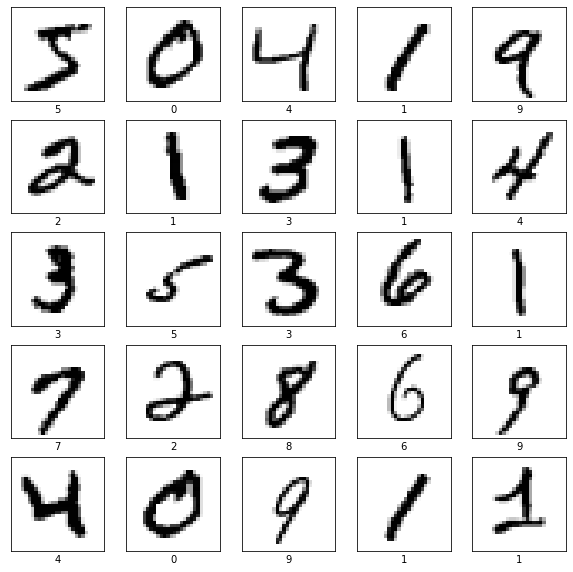

In [5]:
plt.figure(figsize=(10,10))
for i in range(25):
  plt.subplot(5, 5, i+1)
  plt.imshow(trainX[i], cmap='gray_r')
  plt.xlabel(trainy[i])
  plt.xticks([])
  plt.yticks([])

## Discriminator Model

In [0]:
from tensorflow.keras.optimizers import Adam

In [0]:
def define_discriminator(in_shape=(28, 28, 1)):
  model = tf.keras.Sequential()
  model.add(layers.Conv2D(64, (3,3), strides=(2,2), padding='same', input_shape=in_shape))
  model.add(layers.LeakyReLU(alpha=0.2))
  model.add(layers.Dropout(0.4))
  model.add(layers.Conv2D(64, (3,3), strides=(2,2), padding='same'))
  model.add(layers.LeakyReLU(alpha=0.2))
  model.add(layers.Dropout(0.4))
  model.add(layers.Flatten())
  model.add(layers.Dense(1, activation='sigmoid'))

  opt = Adam(lr=0.0002, beta_1=0.5)
  model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
  return model

In [8]:
model = define_discriminator()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 14, 14, 64)        640       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 14, 14, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 7, 7, 64)          36928     
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 7, 7, 64)          0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 7, 7, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 3136)              0

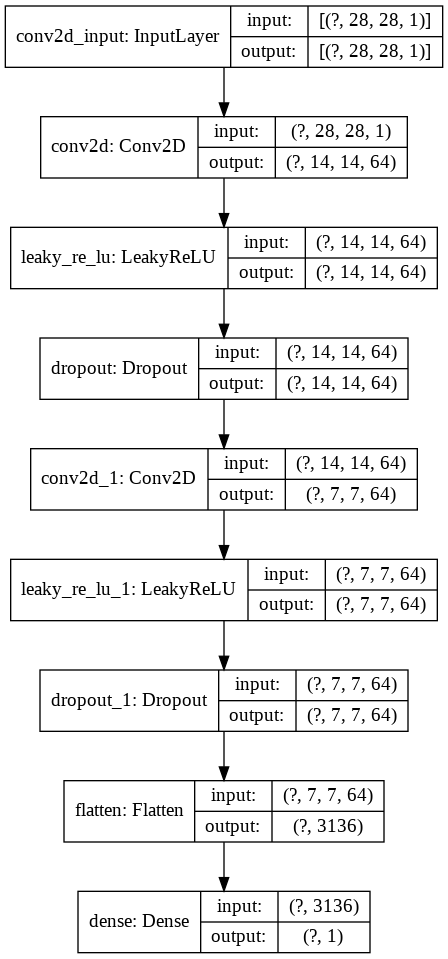

In [9]:
plot_model(model, to_file='discriminator_plot.png', show_shapes=True, show_layer_names=True)

## Train standalone Discriminator

In [0]:
def load_real_samples():
  (trainX, _), (_, _) = load_data()
  X = np.expand_dims(trainX, axis=-1)
  X = X.astype('float32')
  X = X / 255.0
  return X

In [0]:
def generate_real_samples(dataset, n_samples):
  ix = np.random.randint(0, dataset.shape[0], n_samples)
  X = dataset[ix]
  y = np.ones((n_samples,1))
  return X, y

In [0]:
def generate_fake_samples(n_samples):
  X = np.random.rand(28*28*n_samples)
  X = X.reshape((n_samples, 28, 28, 1))
  y = np.zeros((n_samples,1))
  return X, y 

In [0]:
def train_discriminator(model, dataset, n_iter=100, n_batch=256):
  half_batch = int(n_batch/2)
  for i in range(n_iter):
    X_real, y_real = generate_real_samples(dataset, half_batch)
    _, real_acc = model.train_on_batch(X_real, y_real)
    X_fake, y_fake = generate_fake_samples(half_batch)
    _, fake_acc = model.train_on_batch(X_fake, y_fake)
    print('>%d real=%.0f%% fake=%.0f%%' % (i+1, real_acc*100, fake_acc*100))

In [0]:
#model = define_discriminator()
#dataset = load_real_samples()
#train_discriminator(model, dataset)

## Generator Model

In [0]:
def define_generator(latent_dim):
  model = tf.keras.Sequential()
  #128 feature maps and 7x7 resolution image
  n_nodes = 128*7*7
  model.add(layers.Dense(n_nodes, input_dim=latent_dim))
  model.add(layers.LeakyReLU(alpha=0.2))
  model.add(layers.Reshape((7,7,128)))
  model.add(layers.Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
  model.add(layers.LeakyReLU(alpha=0.2))
  model.add(layers.Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
  model.add(layers.LeakyReLU(alpha=0.2))
  model.add(layers.Conv2D(1, (7,7), activation='sigmoid', padding='same'))
  return model

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 6272)              633472    
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 6272)              0         
_________________________________________________________________
reshape (Reshape)            (None, 7, 7, 128)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 14, 14, 128)       262272    
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 28, 28, 128)       262272    
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 28, 28, 128)      

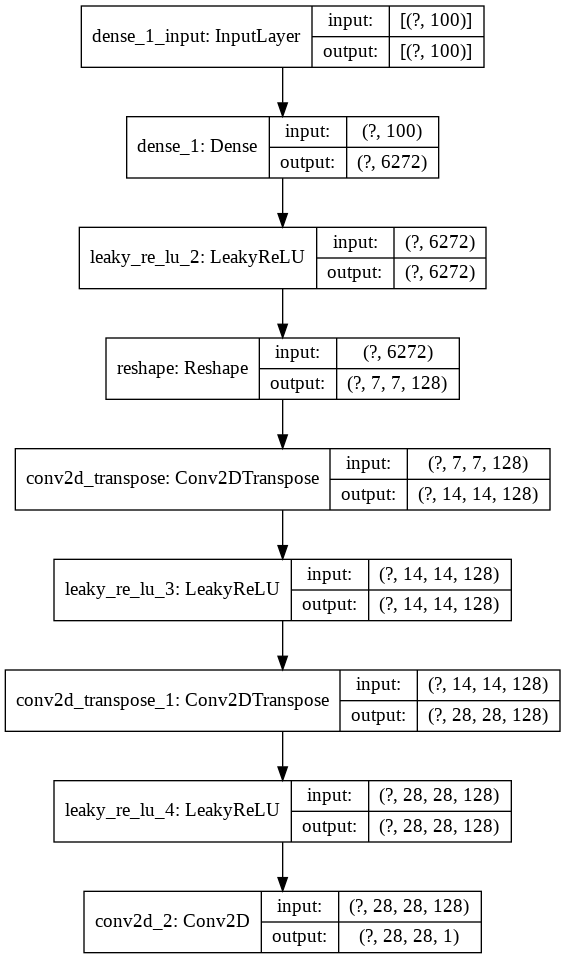

In [16]:
latent_dim = 100
model = define_generator(latent_dim)
model.summary()
plot_model(model, to_file='generator_plot.png', show_shapes=True, show_layer_names=True)

## Sample Image Generation from Untrained Generator

In [0]:
def generate_latent_points(latent_dim, n_samples):
  x_input = np.random.randn(latent_dim * n_samples)
  x_input = x_input.reshape(n_samples, latent_dim)
  return x_input

In [0]:
def generate_fake_samples(g_model, latent_dim, n_samples):
  x_input = generate_latent_points(latent_dim, n_samples)
  X = g_model.predict(x_input)
  y = np.zeros((n_samples,1))
  return X, y

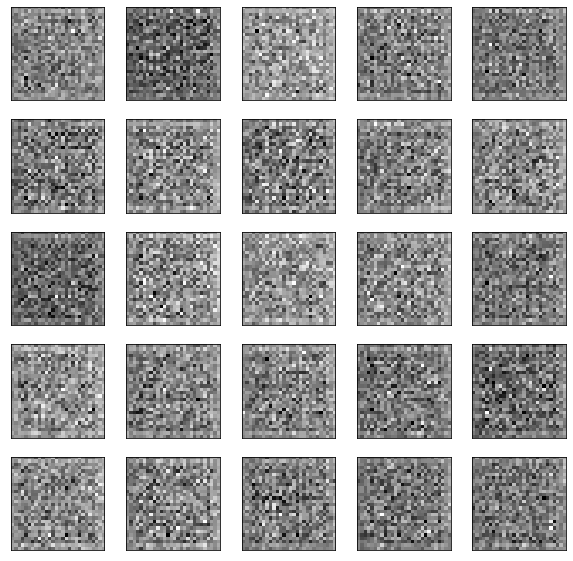

In [19]:
latent_dim = 100
model = define_generator(latent_dim)
n_samples = 25
X, _ = generate_fake_samples(model, latent_dim, n_samples)
plt.figure(figsize=(10,10))
for i in range(n_samples):
  plt.subplot(5,5,i+1)
  plt.imshow(X[i,:,:,0], cmap='gray_r')
  plt.xticks([])
  plt.yticks([])

## GAN Model

In [0]:
def define_gan(g_model, d_model):
  d_model.trainable = False
  model = tf.keras.Sequential()
  model.add(g_model)
  model.add(d_model)
  opt = tf.keras.optimizers.Adam(lr=0.0002, beta_1=0.5)
  model.compile(loss='binary_crossentropy', optimizer=opt)
  return model

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_4 (Sequential)    (None, 28, 28, 1)         1164289   
_________________________________________________________________
sequential_3 (Sequential)    (None, 1)                 40705     
Total params: 1,204,994
Trainable params: 1,164,289
Non-trainable params: 40,705
_________________________________________________________________


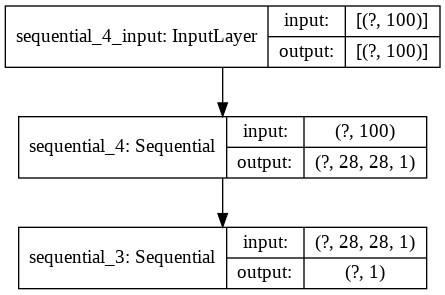

In [21]:
latent_dim = 100
d_model = define_discriminator()
g_model = define_generator(latent_dim)
gan_model = define_gan(g_model, d_model)
gan_model.summary()
plot_model(gan_model, to_file='gan_model.png', show_layer_names=True, show_shapes=True)

## Train and Evaluate GAN Model

In [0]:
def save_plot(examples, epoch, n=10):
  for i in range(n * n):
    plt.subplot(n, n, 1 + i)
    plt.axis('off')
    plt.imshow(examples[i, :, :, 0], cmap='gray_r')
    filename = 'generated_plot_e%03d.png' % (epoch+1) 
  plt.savefig(filename)

In [0]:
def summarize_performance(epoch, g_model, d_model, dataset, latent_dim, n_samples=100):
  X_real, y_real = generate_real_samples(dataset, n_samples)
  _, acc_real = d_model.evaluate(X_real, y_real, verbose=0)
  x_fake, y_fake = generate_fake_samples(g_model, latent_dim, n_samples)
  _, acc_fake = d_model.evaluate(x_fake, y_fake, verbose=0)
  print('>Accuracy real: %.0f%%, fake: %.0f%%' % (acc_real*100, acc_fake*100))
  save_plot(x_fake, epoch)
  filename = 'generator_model_%03d.h5' % (epoch + 1) 
  g_model.save(filename)

In [0]:
def train_gan(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=100, n_batch=256):
  bat_per_epo = int(dataset.shape[0]/n_batch)
  half_batch = int(n_batch/2)
  for i in range(n_epochs):
    for j in range(bat_per_epo):
      X_real, y_real = generate_real_samples(dataset, half_batch)
      X_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
      X, y = np.vstack((X_real, X_fake)), np.vstack((y_real, y_fake))
      d_loss, _ = d_model.train_on_batch(X, y)
      X_gan = generate_latent_points(latent_dim, n_batch)
      y_gan = np.ones((n_batch,1))
      g_loss = gan_model.train_on_batch(X_gan, y_gan)
      print('>%d, %d/%d, d=%.3f, g=%.3f' % (i+1, j+1, bat_per_epo, d_loss, g_loss))
      if (i+1) % 10 == 0 and (j+1) % 50 == 0:
        summarize_performance(i, g_model, d_model, dataset, latent_dim)

>1, 1/234, d=0.706, g=0.681
>1, 2/234, d=0.697, g=0.709
>1, 3/234, d=0.692, g=0.726
>1, 4/234, d=0.680, g=0.753
>1, 5/234, d=0.673, g=0.769
>1, 6/234, d=0.666, g=0.793
>1, 7/234, d=0.656, g=0.811
>1, 8/234, d=0.650, g=0.826
>1, 9/234, d=0.643, g=0.837
>1, 10/234, d=0.646, g=0.845
>1, 11/234, d=0.638, g=0.851
>1, 12/234, d=0.636, g=0.836
>1, 13/234, d=0.642, g=0.825
>1, 14/234, d=0.644, g=0.807
>1, 15/234, d=0.646, g=0.781
>1, 16/234, d=0.644, g=0.762
>1, 17/234, d=0.650, g=0.746
>1, 18/234, d=0.647, g=0.729
>1, 19/234, d=0.645, g=0.720
>1, 20/234, d=0.642, g=0.712
>1, 21/234, d=0.636, g=0.707
>1, 22/234, d=0.632, g=0.702
>1, 23/234, d=0.619, g=0.700
>1, 24/234, d=0.618, g=0.697
>1, 25/234, d=0.606, g=0.697
>1, 26/234, d=0.600, g=0.696
>1, 27/234, d=0.597, g=0.697
>1, 28/234, d=0.580, g=0.696
>1, 29/234, d=0.572, g=0.697
>1, 30/234, d=0.566, g=0.698
>1, 31/234, d=0.553, g=0.698
>1, 32/234, d=0.547, g=0.698
>1, 33/234, d=0.535, g=0.699
>1, 34/234, d=0.525, g=0.700
>1, 35/234, d=0.513, g=

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  This is separate from the ipykernel package so we can avoid doing imports until


Streaming output truncated to the last 5000 lines.
>79, 162/234, d=0.696, g=0.706
>79, 163/234, d=0.692, g=0.693
>79, 164/234, d=0.687, g=0.669
>79, 165/234, d=0.695, g=0.691
>79, 166/234, d=0.688, g=0.732
>79, 167/234, d=0.693, g=0.726
>79, 168/234, d=0.684, g=0.724
>79, 169/234, d=0.691, g=0.695
>79, 170/234, d=0.692, g=0.694
>79, 171/234, d=0.691, g=0.699
>79, 172/234, d=0.691, g=0.707
>79, 173/234, d=0.693, g=0.706
>79, 174/234, d=0.685, g=0.690
>79, 175/234, d=0.690, g=0.687
>79, 176/234, d=0.694, g=0.698
>79, 177/234, d=0.690, g=0.716
>79, 178/234, d=0.690, g=0.689
>79, 179/234, d=0.690, g=0.691
>79, 180/234, d=0.692, g=0.706
>79, 181/234, d=0.693, g=0.713
>79, 182/234, d=0.692, g=0.698
>79, 183/234, d=0.691, g=0.704
>79, 184/234, d=0.690, g=0.693
>79, 185/234, d=0.689, g=0.697
>79, 186/234, d=0.691, g=0.702
>79, 187/234, d=0.689, g=0.708
>79, 188/234, d=0.686, g=0.713
>79, 189/234, d=0.696, g=0.691
>79, 190/234, d=0.693, g=0.679
>79, 191/234, d=0.684, g=0.693
>79, 192/234, d=0.6

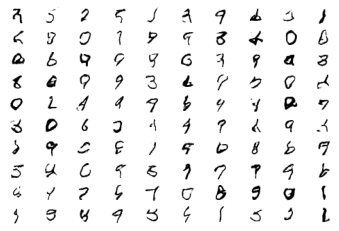

In [25]:
latent_dim = 100
d_model = define_discriminator()
g_model = define_generator(latent_dim)
gan_model = define_gan(g_model, d_model)
dataset = load_real_samples()
train_gan(g_model, d_model, gan_model, dataset, latent_dim)

(-0.5, 431.5, 287.5, -0.5)

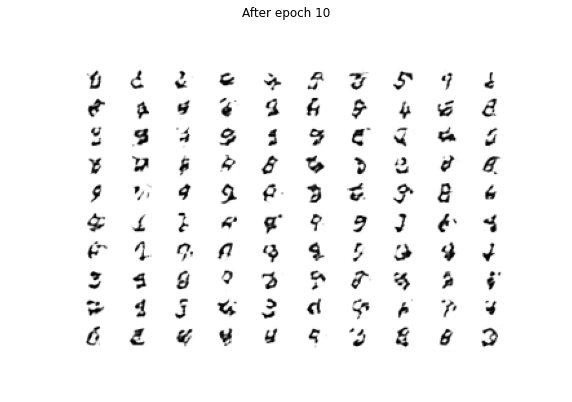

In [26]:
img = plt.imread('/content/generated_plot_e010.png')
plt.figure(figsize=(10,10))
plt.title("After epoch 10")
plt.imshow(img)
plt.axis('off')

(-0.5, 431.5, 287.5, -0.5)

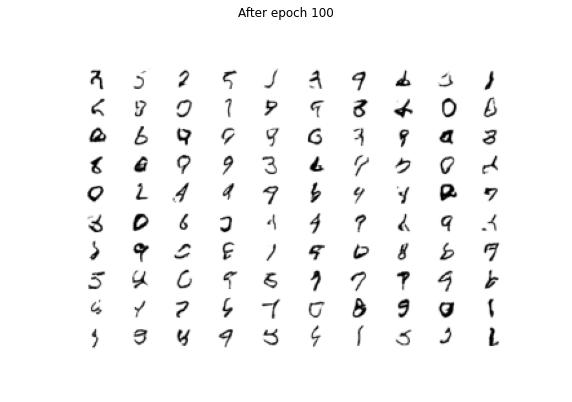

In [27]:
img = plt.imread('/content/generated_plot_e100.png')
plt.figure(figsize=(10,10))
plt.title("After epoch 100")
plt.imshow(img)
plt.axis('off')